In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import quandl as q
from nelson_siegel_svensson import NelsonSiegelSvenssonCurve, NelsonSiegelCurve
from nelson_siegel_svensson.calibrate import calibrate_ns_ols, calibrate_nss_ols
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
plt.style.use("ggplot")

In [2]:
# Get Treasury Yield Data from Quandl

# Toggle for daily data
daily = False
if daily:
    print("Yield Curve Calcs for Daily Data")
    yields = q.get("USTREASURY/YIELD")
else:
    print("Yield Curve Calcs for Monthly Data")
    yields = q.get("USTREASURY/YIELD", collapse="monthly")
    yields.index = yields.index + pd.offsets.MonthBegin(-1)


# Convert Tenors to Years
tenors = np.array([1/12, 2/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])
# Copy the data and rename columns
data = yields.copy()
# data.columns = tenors
# Convert to percentage
data /= 100
# Copy data frame to fill with fitted values
fitted_yields = data.copy()

for idx, row in data.iterrows():
    # Get the rates
    y = row.values
    # We have NaNs in the dataframe so need to drop,
    # we can create mask to drop maturity too
    mask = np.where(~np.isnan(y))[0]
    ys = y[mask]
    ts = tenors[mask]
    # Fit Nelson-Siegel Model
    try:
        # Calibrate model
        curve_fit, status1 = calibrate_ns_ols(ts, ys)
        # Set curve to dataframe
        fitted_yields.loc[idx] = NelsonSiegelCurve.zero(curve_fit, tenors)
    # Catch errors and pass
    except np.linalg.LinAlgError as err:
        pass

# Toggle to drop rates greater than max in entire dataframe
use_ceiling = True

if use_ceiling:
    print("Using ceiling of max rate in original dataframe.")
    fitted_yields.dropna(inplace=True)

    # We do get some bad fits, so we set ceiling with market data
    ceiling = data.select_dtypes(include=[np.number]).max().max()
    l1 = len(fitted_yields)
    fitted_yields = fitted_yields.where(fitted_yields <= ceiling).dropna()
    l2 = len(fitted_yields)
    if l1 != l2:
        print(f"\nDropped {abs(l1-l2)} values greater than max rate of {(ceiling*100):.2f}%.")
    fitted_yields

# print("Original Dataframe Summary Statistics")
# print(yields.describe().round(2).to_latex())

# print("Fitted Data Summary Statistics")
# print((fitted_yields * 100).describe().round(2).to_latex())

Yield Curve Calcs for Monthly Data
Using ceiling of max rate in original dataframe.

Dropped 1 values greater than max rate of 9.06%.


In [42]:
# yields.to_csv("../Data/daily_yields.csv")
# yields.to_csv("../Data/monthly_yields.csv")
# (fitted_yields * 100).to_csv("../Data/daily_ns_yields_ceil.csv")
# (fitted_yields * 100).to_csv("../Data/monthly_ns_yields_ceil.csv")
# (fitted_yields * 100).to_csv("../Data/daily_ns_yields.csv")
# (fitted_yields * 100).to_csv("../Data/monthly_ns_yields.csv")

In [3]:
# Match the indexes
yields = yields[yields.index.isin(fitted_yields.index)]
# Convert to percentages
yields /= 100
# Fill the yield NaNs with zeros
filled_true = yields.fillna(0)
# Copy and get data where its zero, 
# else its the fitted yield value
filled_fitted = fitted_yields.copy()
filled_fitted = filled_true.where(filled_true == 0, filled_fitted)
# Calcualte MSE
mse_ = mean_squared_error(filled_true, filled_fitted)
print(f"MSE comparing applicable market data to Nelson-Siegel fitted data: {mse_*100:.6f}%.")
print(f"{mse_=}")

MSE comparing applicable market data to Nelson-Siegel fitted data: 0.000055%.
mse_=5.458920849548265e-07


/Users/wyattnechtman/miniforge3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


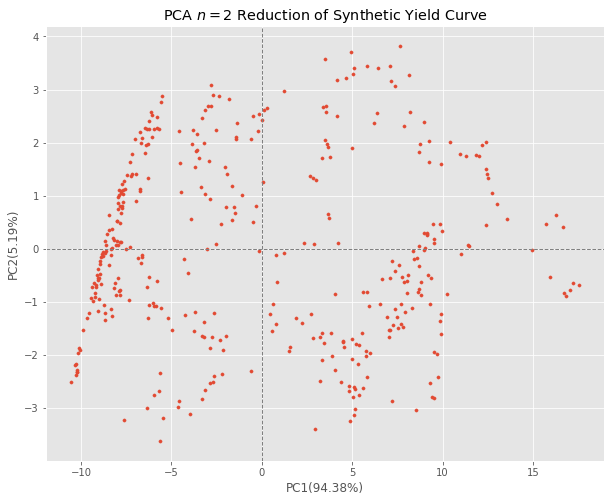

In [4]:
pca_data = fitted_yields.copy()
tenors = np.array([1/12, 2/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])
pca_data.columns = tenors
pca_data *= 100
# pca = PCA(n_components=len(tenors))
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(pca_data)
plt.figure(figsize=(10, 8))
plt.scatter(reduced_data[:,0], reduced_data[:,1], s=10)
plt.axhline(y=0, color="grey", linewidth=1, linestyle="--")
plt.axvline(x=0, color="grey", linewidth=1, linestyle="--")
plt.xlabel(f"PC1({pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PC2({pca.explained_variance_ratio_[1]*100:.2f}%)")
plt.title(r"PCA $n=2$ Reduction of Synthetic Yield Curve")
plt.show()

In [8]:
pd.DataFrame(reduced_data).head()

,0,1
0,16.816962,-0.890689
1,17.052419,-0.772303
2,17.521949,-0.689054
3,17.204252,-0.641668
4,16.714215,-0.826275


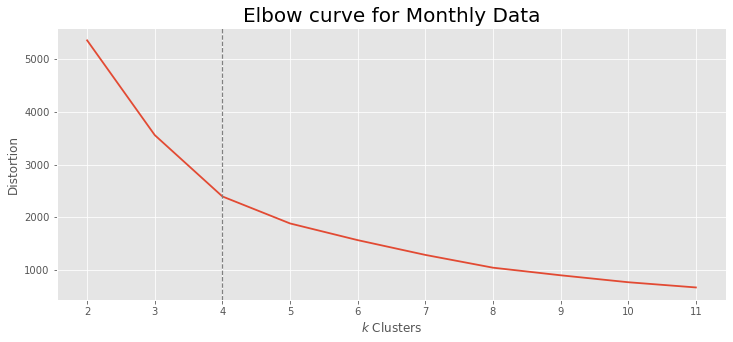

In [42]:
# Copy our PCA reduction
X = reduced_data.copy()
# List to store our distortion values
distorsions = []
# Loop through k values of 2 - 11
for k in range(2, 12):
    # Fit a k-means model
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    # Append our distortion
    distorsions.append(kmeans.inertia_)
# Plot
fig = plt.figure(figsize=(12, 5))
plt.plot(range(2, 12), distorsions, linewidth=1.8)
plt.grid(True)
plt.title('Elbow curve for Monthly Data', fontsize=20)
plt.xticks(np.arange(2,12,1))
plt.axvline(x=4, linewidth=1.2, linestyle="--", color="grey")
plt.xlabel(r"$k$ Clusters")
plt.ylabel("Distortion")
plt.show()

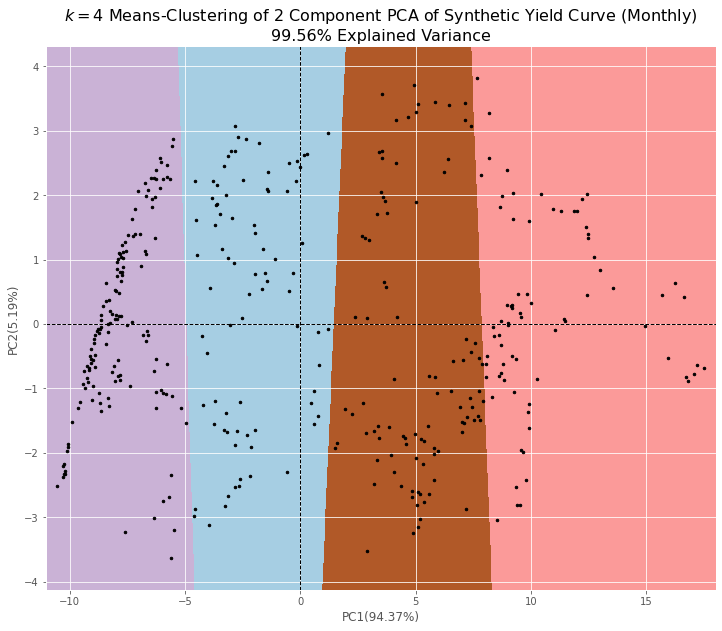

In [43]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(reduced_data)

h = 0.02

w = 0.5

x_min, x_max = reduced_data[:, 0].min() - w, reduced_data[:, 0].max() + w
y_min, y_max = reduced_data[:, 1].min() - w, reduced_data[:, 1].max() + w
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure(figsize=(12, 10))
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)
plt.axhline(y=0, color="black", linewidth=1, linestyle="--")
plt.axvline(x=0, color="black", linewidth=1, linestyle="--")
plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=5)
plt.xlabel(f"PC1({pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PC2({pca.explained_variance_ratio_[1]*100:.2f}%)")
# plt.title(r"Clustering of PCA $n=2$ Reduction of Synthetic Yield Curve (Monthly)", fontsize=16)
title_ = r"$k=4$ Means-Clustering of 2 Component PCA of Synthetic Yield Curve (Monthly)" + "\n" + f"{pca.explained_variance_ratio_[:2].sum():.2%} Explained Variance"
plt.title(title_, fontsize=16)
plt.show()

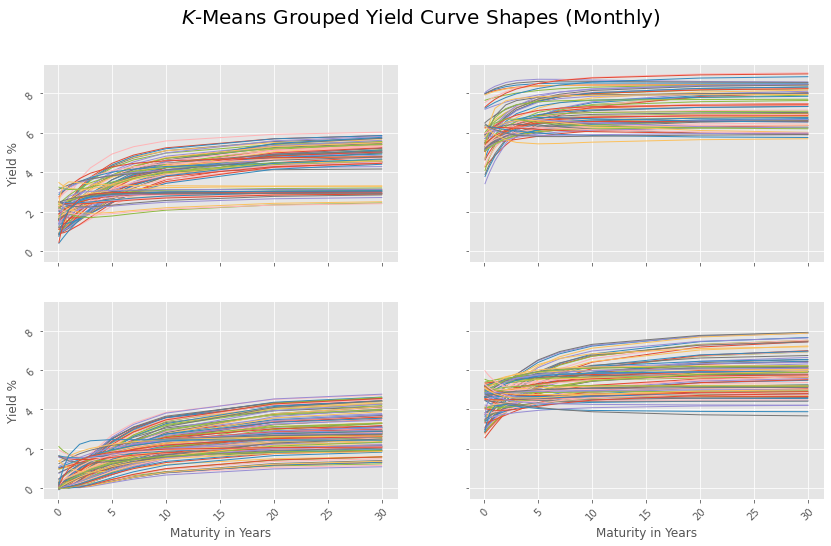

In [44]:
labeled = pca_data.copy()
labeled.loc[:,"Label"] = kmeans.predict(reduced_data)
g1 = labeled.loc[labeled.loc[:,"Label"] == 0].drop("Label", axis = 1).T
g2 = labeled.loc[labeled.loc[:,"Label"] == 1].drop("Label", axis = 1).T
g3 = labeled.loc[labeled.loc[:,"Label"] == 2].drop("Label", axis = 1).T
g4 = labeled.loc[labeled.loc[:,"Label"] == 3].drop("Label", axis = 1).T
fig, axs = plt.subplots(2, 2, figsize=(14,8), sharex=True, sharey=True)
fig.suptitle(r'$K$-Means Grouped Yield Curve Shapes (Monthly)', fontsize=20)
axs[0, 0].plot(g1, linewidth=1)
axs[0, 1].plot(g2, linewidth=1)
axs[1, 0].plot(g3, linewidth=1)
axs[1, 1].plot(g4, linewidth=1)
for ax in axs.flat:
    ax.set_xlabel("Maturity in Years")
    ax.set_ylabel("Yield %")
    ax.label_outer()
    ax.tick_params(labelrotation=45)
plt.show()

In [45]:
labeled["Label"].value_counts()

2    142
3     95
0     82
1     75
Name: Label, dtype: int64

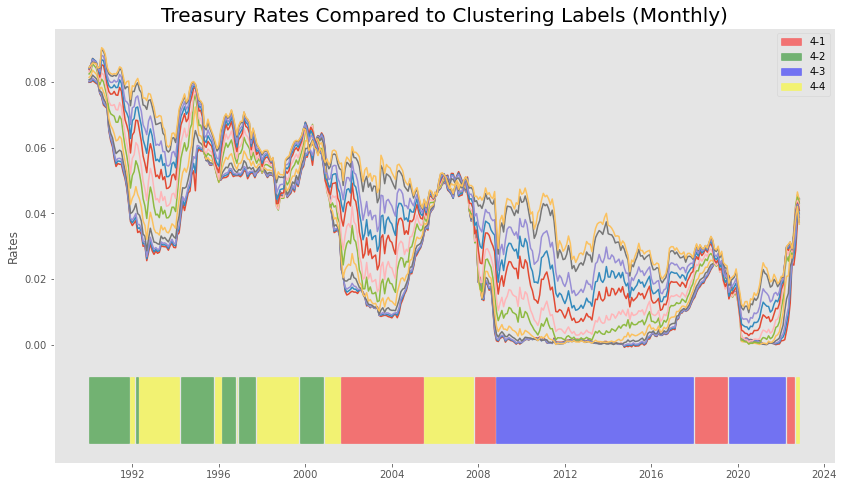

In [47]:
labeled_ = labeled.copy()
labeled_ /= 100
labeled_["Label"] = labeled["Label"]
fig, ax = plt.subplots(figsize=(14,8))
ax.plot(labeled_.drop(["Label"], axis=1))
ax.set_title("Treasury Rates Compared to Clustering Labels (Monthly)", fontsize=20)
ax.set_yticks(ticks = [i for i in np.arange(0, .1, .02)])
ax.set_ylabel("Rates")
ax.fill_between(x=labeled_.index, y1=-0.03, y2=-0.01, where=(labeled_["Label"] == 0), color="red", alpha=0.5, label="4-1")
ax.fill_between(x=labeled_.index, y1=-0.03, y2=-0.01, where=(labeled_["Label"] == 1), color="green", alpha=0.5, label="4-2")
ax.fill_between(x=labeled_.index, y1=-0.03, y2=-0.01, where=(labeled_["Label"] == 2), color="blue", alpha=0.5, label="4-3")
ax.fill_between(x=labeled_.index, y1=-0.03, y2=-0.01, where=(labeled_["Label"] == 3), color="yellow", alpha=0.5, label="4-4")
ax.legend(loc=1)
ax.grid()

In [31]:
labeled = labeled_.copy()
labeled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8224 entries, 1990-01-02 to 2022-11-28
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   0.08333333333333333  8224 non-null   float64
 1   0.16666666666666666  8224 non-null   float64
 2   0.25                 8224 non-null   float64
 3   0.5                  8224 non-null   float64
 4   1.0                  8224 non-null   float64
 5   2.0                  8224 non-null   float64
 6   3.0                  8224 non-null   float64
 7   5.0                  8224 non-null   float64
 8   7.0                  8224 non-null   float64
 9   10.0                 8224 non-null   float64
 10  20.0                 8224 non-null   float64
 11  30.0                 8224 non-null   float64
 12  Label                8224 non-null   int32  
dtypes: float64(12), int32(1)
memory usage: 867.4 KB


In [32]:
labeled["Label"].value_counts()

0     1420
6     1260
1     1212
4      834
8      789
2      778
9      518
10     507
7      366
5      307
3      233
Name: Label, dtype: int64

In [106]:
# Load and clean Fama-French Data

# 3 Factor
# data = pd.read_csv("../Data/F-F_Research_Data_Factors.CSV", skiprows=2).iloc[:-98, :]
# ff3_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip"
# data = pd.read_csv(ff3_url, skiprows=2).iloc[:-98, :]

# 5 Factor
# data = pd.read_csv("../Data/F-F_Research_Data_5_Factors_2x3.csv", skiprows=2).iloc[:-60, :]
ff5_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip"
data = pd.read_csv(ff5_url, skiprows=2).iloc[:-60, :]

data.columns = ["Date", "Mkt_RF", "SMB", "HML", "RMW", "CMA", "RF"]
data["Date"] = pd.to_datetime(data["Date"], format="%Y%m")
data.set_index("Date", inplace=True)
data = data.astype(float)
data /= 100

# Add momentum
mom = pd.read_csv("http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Momentum_Factor_CSV.zip", skiprows=12).iloc[:-99, :]
mom.columns = ["Date", "MOM"]
mom["Date"] = pd.to_datetime(mom["Date"], format="%Y%m")
mom.set_index("Date", inplace=True)
mom = mom.astype(float)
mom /= 100

# Merge
data = pd.merge(data, mom, left_index=True, right_index=True)
data = data[["Mkt_RF", "SMB", "HML", "RMW", "CMA", "MOM", "RF"]]

# Select since date
# since_y = "1963"
# Or all data
since_y = str(data.index.min().year)
data = data[since_y:]
data.head()

,Mkt_RF,SMB,HML,RMW,CMA,MOM,RF
Date,,,,,,,
1963-07-01,-0.0039,-0.0041,-0.0097,0.0068,-0.0118,0.0090,0.0027
1963-08-01,0.0507,-0.0080,0.0180,0.0036,-0.0035,0.0101,0.0025
1963-09-01,-0.0157,-0.0052,0.0013,-0.0071,0.0029,0.0019,0.0027
1963-10-01,0.0253,-0.0139,-0.0010,0.0280,-0.0201,0.0312,0.0029
1963-11-01,-0.0085,-0.0088,0.0175,-0.0051,0.0224,-0.0074,0.0027


In [107]:
labeled_ff = pd.merge(data, labeled["Label"], left_index=True, right_index=True)

In [108]:
res = labeled_ff.groupby("Label").mean().style.highlight_max(color='green', axis=1).highlight_min(color='red', axis=1).format("{:.4f}")
display(res)
display(labeled_ff.groupby("Label").agg(['mean', 'std', 'count']).round(4).style.highlight_max(color='green', axis=0).highlight_min(color='red', axis=0))

,Mkt_RF,SMB,HML,RMW,CMA,MOM,RF
Label,,,,,,,
0,-0.0034,0.0044,0.0023,0.0051,0.0021,0.0068,0.0014
1,0.0072,-0.0004,0.0026,0.0052,0.0021,0.0114,0.0046
2,0.0071,0.0009,0.0039,0.0023,0.0036,0.0090,0.0035
3,0.0128,0.0010,-0.0009,0.0027,0.0015,-0.0027,0.0002


In [116]:
# See that labels here:
# THIS IS FOR WHEN YIELD DATA AQUIRED BY DAY
#   0 - Best: SMB | Worst: MOM
#   1 - Best: MOM | Worst: SMB
#   2 - Best: MKT | Worst: MOM
#   3 - Best: MOM | Worst: CMA

# df0 = pd.DataFrame(columns=["Long", "Short"], index=labeled_ff.index)
# df0["Long"] = labeled_ff[labeled_ff["Label"] == 0]["SMB"]
# df0["Short"] = labeled_ff[labeled_ff["Label"] == 0]["MOM"]
# df0.dropna(inplace=True)

# df1 = pd.DataFrame(columns=["Long", "Short"], index=labeled_ff.index)
# df1["Long"] = labeled_ff[labeled_ff["Label"] == 1]["MOM"]
# df1["Short"] = labeled_ff[labeled_ff["Label"] == 1]["SMB"]
# df1.dropna(inplace=True)

# df2 = pd.DataFrame(columns=["Long", "Short"], index=labeled_ff.index)
# df2["Long"] = labeled_ff[labeled_ff["Label"] == 2]["Mkt_RF"]
# df2["Short"] = labeled_ff[labeled_ff["Label"] == 2]["MOM"]
# df2.dropna(inplace=True)

# df3 = pd.DataFrame(columns=["Long", "Short"], index=labeled_ff.index)
# df3["Long"] = labeled_ff[labeled_ff["Label"] == 3]["MOM"]
# df3["Short"] = labeled_ff[labeled_ff["Label"] == 3]["CMA"]
# df3.dropna(inplace=True)

# df = pd.concat([df0, df1, df2, df3])
# df.sort_index(ascending=True, inplace=True)
# df["Portfolio"] = df["Long"] - df["Short"]

# ((df["Portfolio"] + 1).cumprod() - 1).plot(figsize=(12, 8))

# plt.title("Using Yield Curve Labels", fontsize=20)
# plt.show()

# combined = data.copy()
# combined["Portfolio"] = df["Portfolio"]
# ((combined.loc[df.index.min():] + 1).cumprod() - 1).plot(figsize=(12, 8))

# plt.title("Using Yield Curve Labels", fontsize=20)
# plt.show()

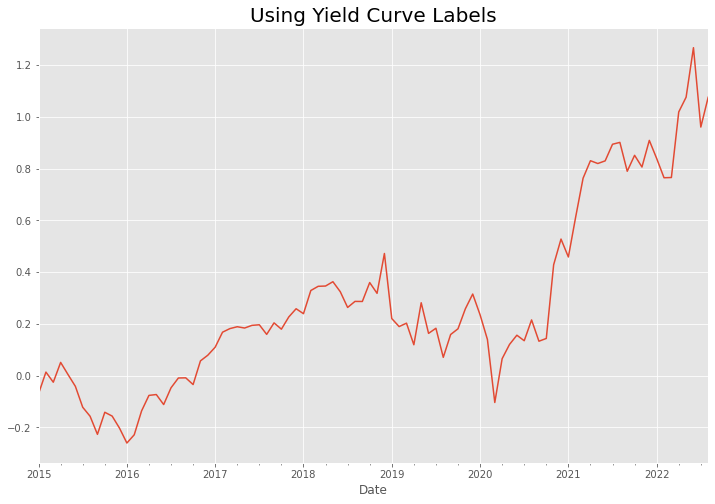

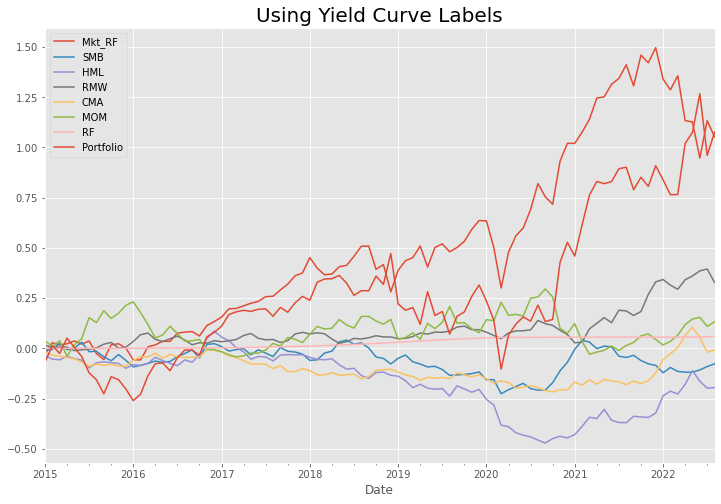

In [119]:
# See that labels here:
# THIS IS FOR WHEN YIELD DATA AQUIRED BY MONTH
#   0 - Best: MOM | Worst: MKT
#   1 - Best: MOM | Worst: SMB
#   2 - Best: MOM | Worst: SMB
#   3 - Best: MKT | Worst: MOM

df0 = pd.DataFrame(columns=["Long", "Short"], index=labeled_ff.index)
df0["Long"] = labeled_ff[labeled_ff["Label"] == 0]["MOM"]
df0["Short"] = labeled_ff[labeled_ff["Label"] == 0]["Mkt_RF"]
df0.dropna(inplace=True)

df1 = pd.DataFrame(columns=["Long", "Short"], index=labeled_ff.index)
df1["Long"] = labeled_ff[labeled_ff["Label"] == 1]["MOM"]
df1["Short"] = labeled_ff[labeled_ff["Label"] == 1]["SMB"]
df1.dropna(inplace=True)

df2 = pd.DataFrame(columns=["Long", "Short"], index=labeled_ff.index)
df2["Long"] = labeled_ff[labeled_ff["Label"] == 2]["MOM"]
df2["Short"] = labeled_ff[labeled_ff["Label"] == 2]["SMB"]
df2.dropna(inplace=True)

df3 = pd.DataFrame(columns=["Long", "Short"], index=labeled_ff.index)
df3["Long"] = labeled_ff[labeled_ff["Label"] == 3]["Mkt_RF"]
df3["Short"] = labeled_ff[labeled_ff["Label"] == 3]["MOM"]
df3.dropna(inplace=True)

df = pd.concat([df0, df1, df2, df3])
df.sort_index(ascending=True, inplace=True)
df["Portfolio"] = df["Long"] - df["Short"]

since = "2015"

((df.loc[since:]["Portfolio"] + 1).cumprod() - 1).plot(figsize=(12, 8))

plt.title("Using Yield Curve Labels", fontsize=20)
plt.show()

combined = data.copy()
combined["Portfolio"] = df["Portfolio"]
# ((combined.loc[df.index.min():] + 1).cumprod() - 1).plot(figsize=(12, 8))
((combined.loc[since:] + 1).cumprod() - 1).plot(figsize=(12, 8))

plt.title("Using Yield Curve Labels", fontsize=20)
plt.show()